[*********************100%***********************]  1 of 1 completed
Epoch 1/1000
22/22 [==============================] - 13s 174ms/step - loss: 0.1558 - val_loss: 0.1342
Epoch 2/1000
22/22 [==============================] - 2s 76ms/step - loss: 0.0736 - val_loss: 0.0616
Epoch 3/1000
22/22 [==============================] - 2s 76ms/step - loss: 0.0349 - val_loss: 0.0312
Epoch 4/1000
22/22 [==============================] - 2s 77ms/step - loss: 0.0174 - val_loss: 0.0198
Epoch 5/1000
22/22 [==============================] - 2s 76ms/step - loss: 0.0132 - val_loss: 0.0172
Epoch 6/1000
22/22 [==============================] - 2s 77ms/step - loss: 0.0110 - val_loss: 0.0157
Epoch 7/1000
22/22 [==============================] - 2s 78ms/step - loss: 0.0104 - val_loss: 0.0148
Epoch 8/1000
22/22 [==============================] - 2s 77ms/step - loss: 0.0095 - val_loss: 0.0131
Epoch 9/1000
22/22 [==============================] - 2s 76ms/step - loss: 0.0086 - val_loss: 0.0129
Epoch 10/1000
22/22 

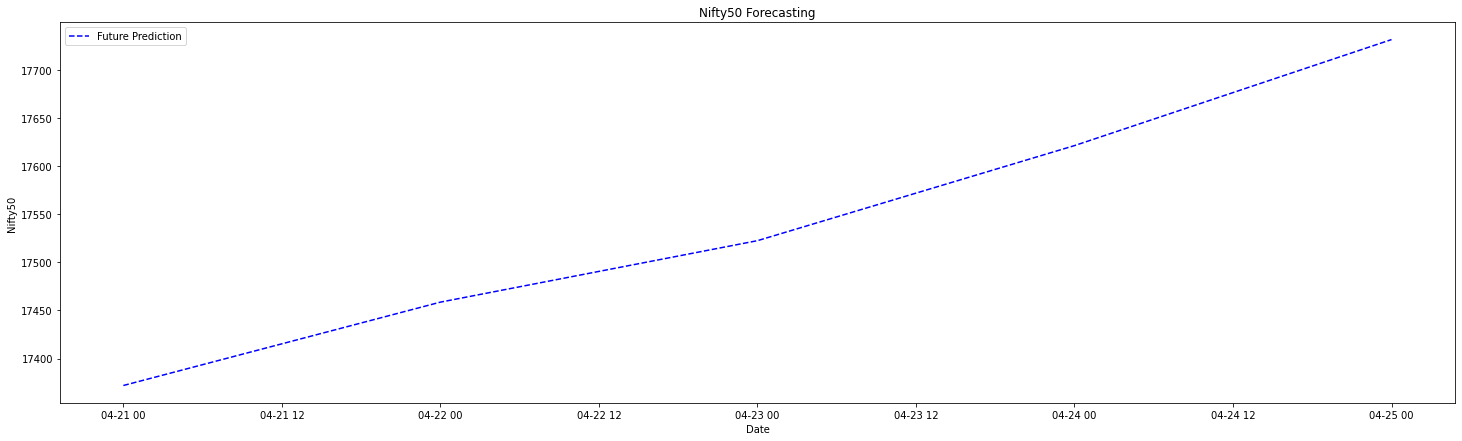

In [8]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
!pip install yfinance
import yfinance as yf  
from datetime import date
from pandas_datareader import data as pdr
yf.pdr_override()

# deep learning libraries
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

# fetch data for training
def SaveData(df, filename):
  df.to_csv(filename + '.csv')
today = date.today()
dataname='^NSEI'+'_'+str(today)
data=pdr.get_data_yahoo('^NSEI', start='2015-01-01', end=today)
SaveData(data, dataname)
data= pd.read_csv(dataname+'.csv')

# drop not required column
data.drop(columns=['Adj Close'], inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# 80% will be used for traning, and 20% for testing
train_size = 0.8       # 80%
split_index = int(train_size * data.shape[0])

factors_column = ['Open', 'High', 'Low', 'Close', 'Volume']
y_col_index = 3 # Close

train_set = data[factors_column].values[:split_index]
test_set = data[factors_column].values[split_index:]

# scale our price from 0 to 1
sc = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.fit_transform(test_set)

# Predicting Closing Price
# Generate windowed timestamp data
# this function will combine data of 20 days (we can change it using time_window parameter) 
time_window =  28     # 28 days
days_step =1         # skip 1 days in between, can be set to 1 day
def generate_data(series, time_window=4, days_step=1):
  X = []
  y = []
  for i in range(28, len(series)):
    X.append(series[i-time_window: i: days_step])
    y.append(series[i])                                 # <---- only changed this, insetead of taking only closing price, every column value is used
  return (np.array(X), np.array(y))

X_train, y_train = generate_data(train_set_scaled, time_window, days_step)
X_test, y_test = generate_data(test_set_scaled, time_window, days_step)

model = Sequential()

# layer 1
model.add(LSTM(units = 64, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(Dropout(0.2))

# layer 2
model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

# layer 3
model.add(LSTM(units = 16, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 8, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 5))

# Compile and train LSTM Network
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train,
                    y_train,
                    epochs = 1000,
                    batch_size = 64,
                    validation_data = (X_test, y_test))

## future forecasting
def predict_n_days(df, n=30, step=0.1):
    for i in range(n):
        X = df[factors_column].values[df.shape[0]-time_window::step]
        X = sc.transform(X)
        y = model.predict(np.expand_dims(X, axis=0))
        y = sc.inverse_transform(y)[0]

        next_day_prediction = { key: value for key, value in zip(factors_column, y)}
        next_day_prediction['Date'] = df.iloc[-1].Date + pd.Timedelta(days=1)
        
        df = df.append(next_day_prediction, ignore_index=True)
    return df

days= 5    
#days_step =0.1   
predicted_df = predict_n_days(data,days,days_step)

fig = plt.figure(figsize = (25, 7))
#plt.plot(data.Date, data.Close, 'r-', label = 'Option Close')
plt.plot(predicted_df.Date.values[-days: ], predicted_df.Close[-days:], 'b--', label = 'Future Prediction')

plt.title('Nifty50 Forecasting')
plt.xlabel('Date')
plt.ylabel('Nifty50')
plt.legend()
plt.show()

In [9]:
# MLP for OTP model Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# serialize model to JSON
model_json = model.to_json()
with open("model_5_28.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5_28.h5")
print("Saved model to disk")
 


Saved model to disk


In [15]:
# later...
 
# load json and create model
json_file = open('model_5_28.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_5_28.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_train,
                    y_train, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 70.77%


In [16]:
def predict2_n_days(df, n=28, step=0.1):
    for i in range(n):
        X = df[factors_column].values[df.shape[0]-time_window::step]
        X = sc.transform(X)
        y = loaded_model.predict(np.expand_dims(X, axis=0))
        y = sc.inverse_transform(y)[0]

        next_day_prediction = { key: value for key, value in zip(factors_column, y)}
        next_day_prediction['Date'] = df.iloc[-1].Date + pd.Timedelta(days=1)
        
        df = df.append(next_day_prediction, ignore_index=True)
    return df

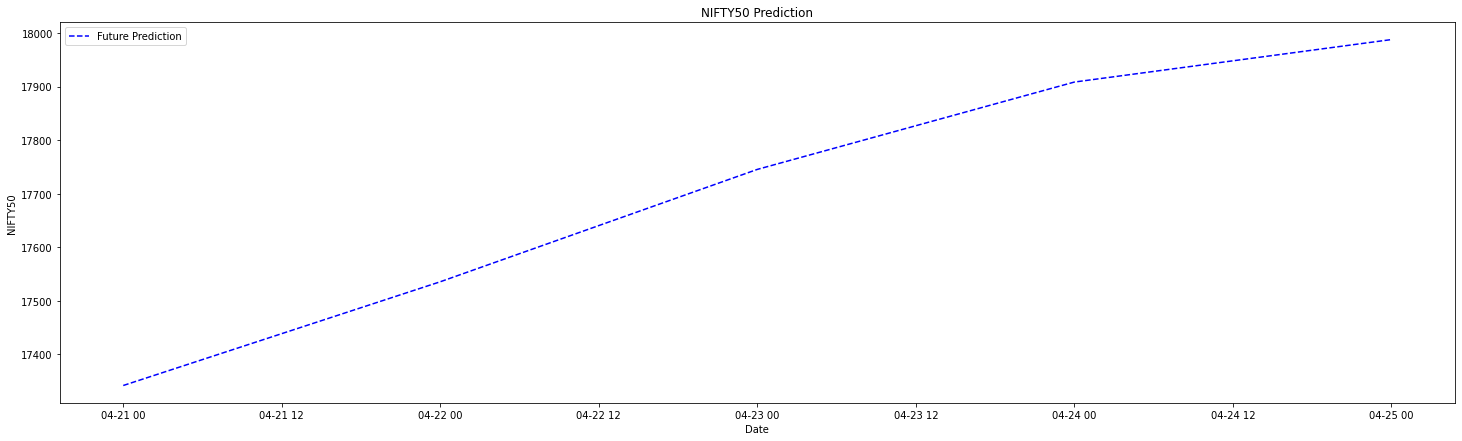

In [17]:
days= 5    
#days_step =0.1   
predicted_df = predict2_n_days(data,days,days_step)
fig = plt.figure(figsize = (25, 7))
#plt.plot(data.Date[-50:], data.Close[-50:], 'r-', label = 'Option Close')
plt.plot(predicted_df.Date.values[-days: ], predicted_df.Close[-days:], 'b--', label = 'Future Prediction')

plt.title('NIFTY50 Prediction')
plt.xlabel('Date')
plt.ylabel('NIFTY50')
plt.legend()
plt.show()

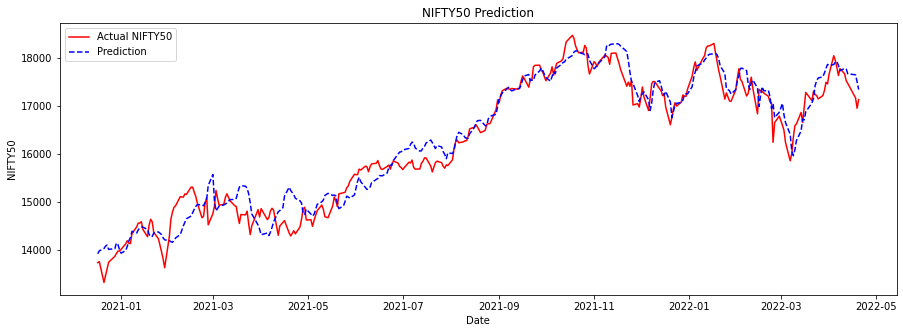

In [13]:

test_prediction = loaded_model.predict(X_test)
test_prediction = sc.inverse_transform(test_prediction)
fig = plt.figure(figsize = (15, 5))
plt.plot(data.Date.values[ split_index+28 : ], data.Close.values[ split_index+28: ], 'r-', label = 'Actual NIFTY50')
plt.plot(data['Date'].values[split_index+28 : ], test_prediction[:,3], 'b--', label = 'Prediction')

plt.title('NIFTY50 Prediction')
plt.xlabel('Date')
plt.ylabel('NIFTY50')
plt.legend()
plt.show()

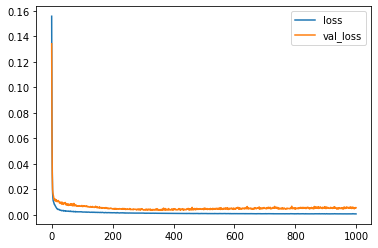

In [14]:
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()